## Outline

* [1. Problem Statement](#0)
* [2. Performance Metrics](#1)
* [3. Dataset Description](#2)
* [4. Exploratory Data Analysis](#3)
    * [4.1 Loading Data](#3.1)    
    * [4.2. Data Visualisations](#3.2)
* [5. Data Preprocessing](#4)
    * [5.1 Categorical Encoding and Imputing Missing Values](#4.1)    
    * [5.2.Splitting data into train and test](#4.2) 
* [6. Training Models](#5)        
    * [6.1.Light GBM Regressor](#5.1)


<a id='0'></a>
## 1. Problem Statement

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

Objective is to predict the natural log of the sum of all transactions per user. 

<a id='1'></a>
## 2. Performance Metrics

Root Mean Squared Error

$\textbf{y}_{user}= \sum_i{\textbf{transaction}_{user}}$

$\textbf{target}_{user} = ln(\textbf{y}_{user} + 1) $

where y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.

<a id='2'></a>
## 3. Dataset Description

- train.csv 903653 rows x 55 columns - Size 1.39 GB

Data Fields

- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp .
- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- totals - This set of columns mostly includes high-level aggregate data.

Due to the formatting of fullVisitorId you must load the Id's as strings in order for all Id's to be properly unique!
There are multiple columns which contain JSON blobs of varying depth. In one of those JSON columns, totals, the sub-column transactionRevenue contains the revenue information we are trying to predict. This sub-column exists only for the training data.



<a id='3'></a>
## 4. Exploratory Data Analysis

<a id='3.1'></a>
## 4.1 Loading data

In [1]:
# Necessary librarys
import os 
import random
import datetime as dt

import pandas as pd
import json
from pandas import json_normalize
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

Two important points when loading data
 - Multiple columns in the dataset contain JSON blobs 
 - fullVisitorId column must be loaded as string

In [2]:
# Helper to load data

columns = ['device', 'geoNetwork', 'totals', 'trafficSource']

def load_df(csv_path='train.csv'):
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Shape: {df.shape}")
    return df

In [3]:
# Loading data

start = dt.datetime.now()
train_df = load_df("train.csv") 
print("Time taken to run this cell :", dt.datetime.now() - start)

Shape: (903653, 55)
Time taken to run this cell : 0:02:28.057087


In [4]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,not available in demo dataset,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Summary of all colums in dataset

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    for i in range(20):
        summary[f'{i} Value'] = df.loc[i].values
    
    return summary

In [6]:
df_summary(train_df)

Dataset Shape: (903653, 55)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,object,0,8,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,...,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
1,date,int64,0,366,20160902,20160902,20160902,20160902,20160902,20160902,...,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902
2,fullVisitorId,object,0,714167,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085,2938943183656635653,...,0523069750702990437,982320996976275749,357659889600827884,1438082600262726746,3531015320757710684,9638207207743070032,9876750586615598787,2222266935962032743,9674781571160116268,3696906537737368442
3,sessionId,object,0,902755,1131660440785968503_1472830385,377306020877927890_1472880147,3895546263509774583_1472865386,4763447161404445595_1472881213,27294437909732085_1472822600,2938943183656635653_1472807194,...,0523069750702990437_1472834967,982320996976275749_1472849434,357659889600827884_1472839882,1438082600262726746_1472803483,3531015320757710684_1472868337,9638207207743070032_1472824614,9876750586615598787_1472801099,2222266935962032743_1472826820,9674781571160116268_1472804607,3696906537737368442_1472856874
4,socialEngagementType,object,0,1,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,...,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
5,visitId,int64,0,886303,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,...,1472834967,1472849434,1472839882,1472803483,1472868337,1472824614,1472801099,1472826820,1472804607,1472856874
6,visitNumber,int64,0,384,1,1,1,1,2,1,...,1,1,1,1,1,1,1,1,1,1
7,visitStartTime,int64,0,887159,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,...,1472834967,1472849434,1472839882,1472803483,1472868337,1472824614,1472801099,1472826820,1472804607,1472856874
8,device.browser,object,0,54,Chrome,Firefox,Chrome,UC Browser,Chrome,Chrome,...,Chrome,Safari,Safari,Safari,Chrome,Chrome,Chrome,Internet Explorer,Chrome,Chrome
9,device.browserVersion,object,0,1,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset


In [7]:
# Check percent of visits that generated revenue

train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
ratio = len(train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].value_counts()) / train_df.shape[0]

print("Percentage of visits that generated revenue = %.3f" %ratio)

Percentage of visits that generated revenue = 0.006


In [8]:
# Check percent of customers that generated revenue

cnt_vis = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
cnt_visr = (cnt_vis["totals.transactionRevenue"]>0).sum()

c_ratio = cnt_visr / cnt_vis.shape[0] 
print("Percentage of customers that generated revenue = %.3f" %c_ratio)

Percentage of customers that generated revenue = 0.014


In [9]:
# Check total revenue generated

rsum = train_df[train_df['totals.transactionRevenue'] > 0]["totals.transactionRevenue"].sum()

print("Total revenue generated = %.2f" %rsum)

Total revenue generated = 1540071240000.00


<a id='3.2'></a>
## 4.2 Data Visualisations

c:\users\administrator\zenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\administrator\zenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


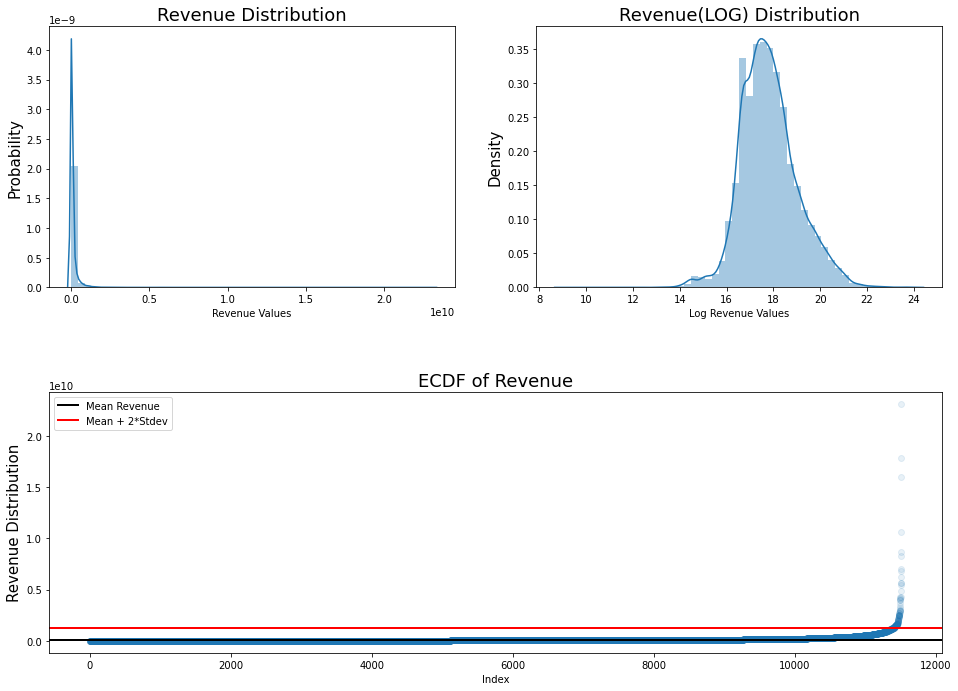

In [10]:
# Plot distributions of target variable

plt.figure(figsize=(16,12))

plt.subplot(221)
g = sns.distplot(train_df["totals.transactionRevenue"])
g.set_title("Revenue Distribution", fontsize=18)
g.set_xlabel("Revenue Values")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(train_df["totals.transactionRevenue"]+1.5))
g1.set_title("Revenue(LOG) Distribution", fontsize=18)
g1.set_xlabel("Log Revenue Values")
g1.set_ylabel("Density", fontsize=15)

plt.subplot(212)
g4 = plt.scatter(range(train_df.shape[0]),
                 np.sort(train_df["totals.transactionRevenue"].values), 
                 alpha=.1)
g4= plt.title("ECDF of Revenue", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Revenue Distribution", fontsize=15)
g4 = plt.axhline(train_df[train_df["totals.transactionRevenue"] > 0]['totals.transactionRevenue'].mean(), color='black', 
           label='Mean Revenue', linewidth=2)
g4 = plt.axhline(train_df[train_df["totals.transactionRevenue"] > 0]['totals.transactionRevenue'].mean() + 
                 (2.5*train_df[train_df["totals.transactionRevenue"] > 0]['totals.transactionRevenue'].std()),
                 color='red', 
           label='Mean + 2*Stdev', linewidth=2)
g4 = plt.legend()

plt.subplots_adjust(hspace = 0.4, top = 0.85)

plt.show()

Graphs and calculations confirm that very small fraction (1.4%) of customers contribute in all of the revenues generated.

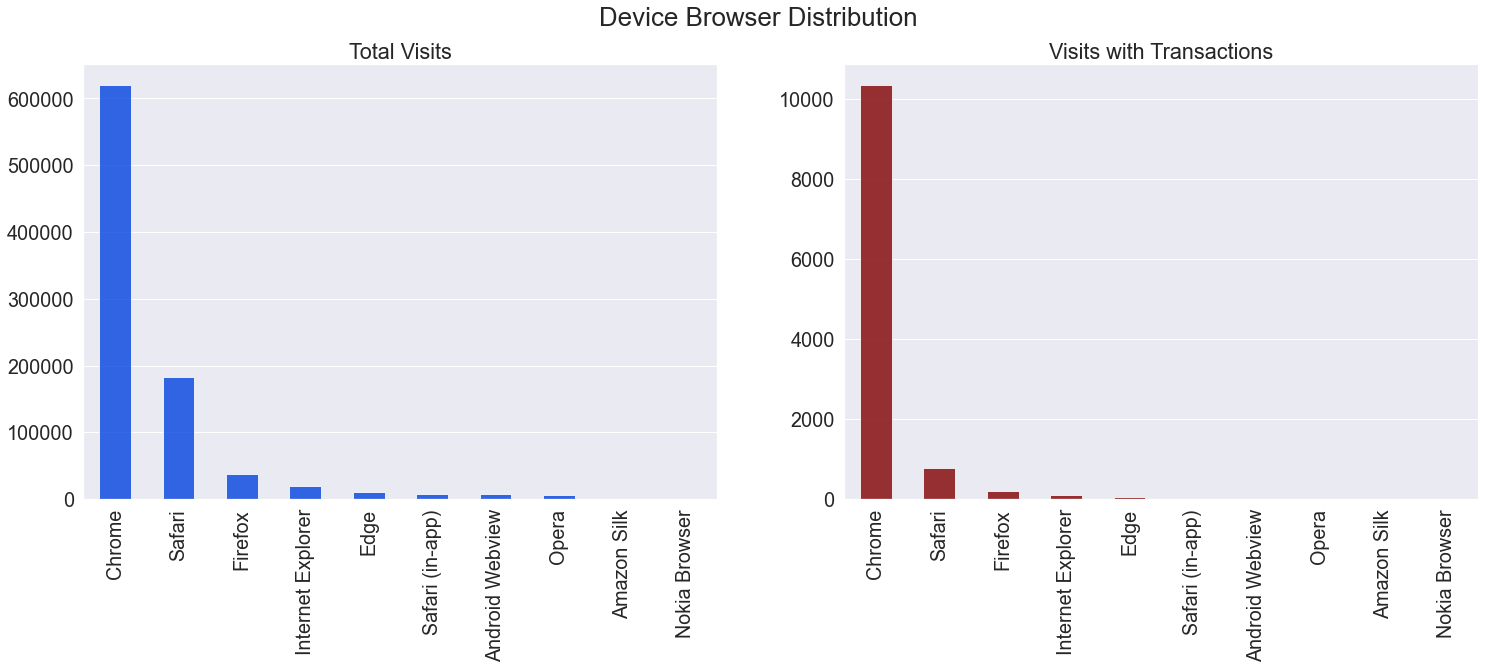

,Total Visits,Visits with Transactions
device.browser,,
Chrome,620364,10353
Safari,182245,780
Firefox,37069,191
Internet Explorer,19375,109
Edge,10205,58
Safari (in-app),6850,12
Android Webview,7865,6
Opera,5643,5
Amazon Silk,561,1


In [11]:
# Device Browser
cnt_brw = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_brw.columns = ["Total Visits", "Visits with Transactions"]
cnt_brw = cnt_brw.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Device Browser Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_brw["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_brw["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_brw

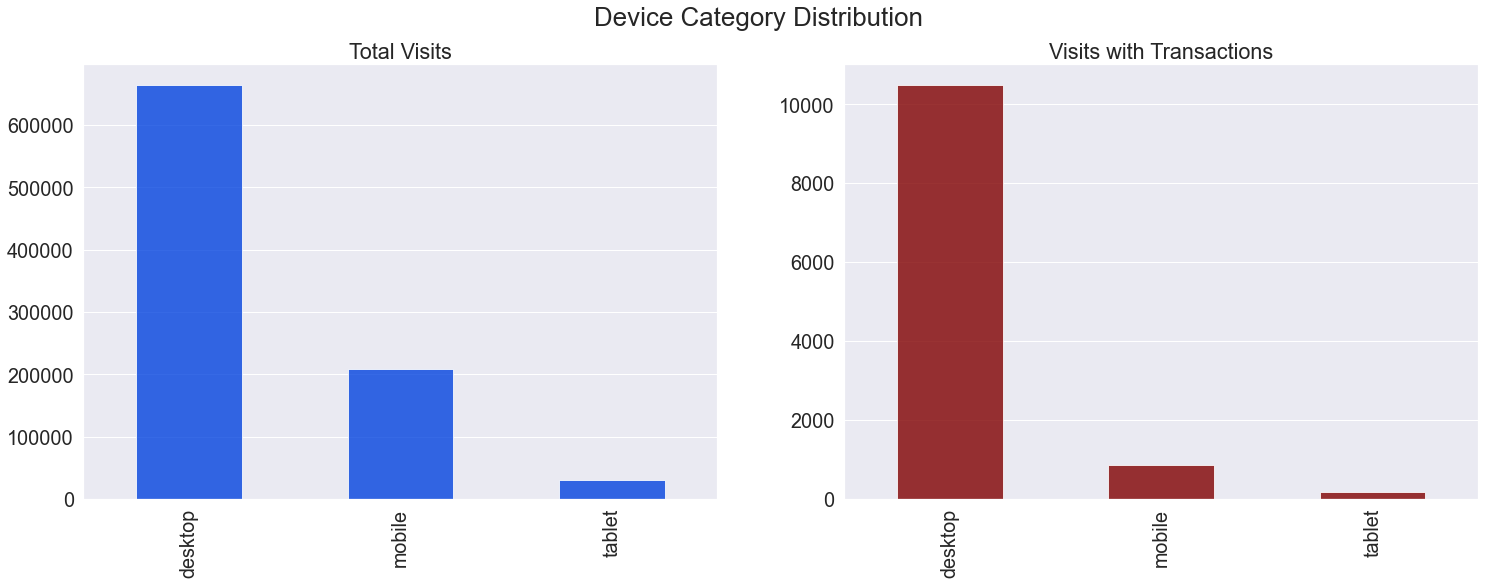

,Total Visits,Visits with Transactions
device.deviceCategory,,
desktop,664479,10495
mobile,208725,852
tablet,30449,168


In [12]:
# Device Category
cnt_dcat = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_dcat.columns = ["Total Visits", "Visits with Transactions"]
cnt_dcat = cnt_dcat.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Device Category Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_dcat["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_dcat["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_dcat

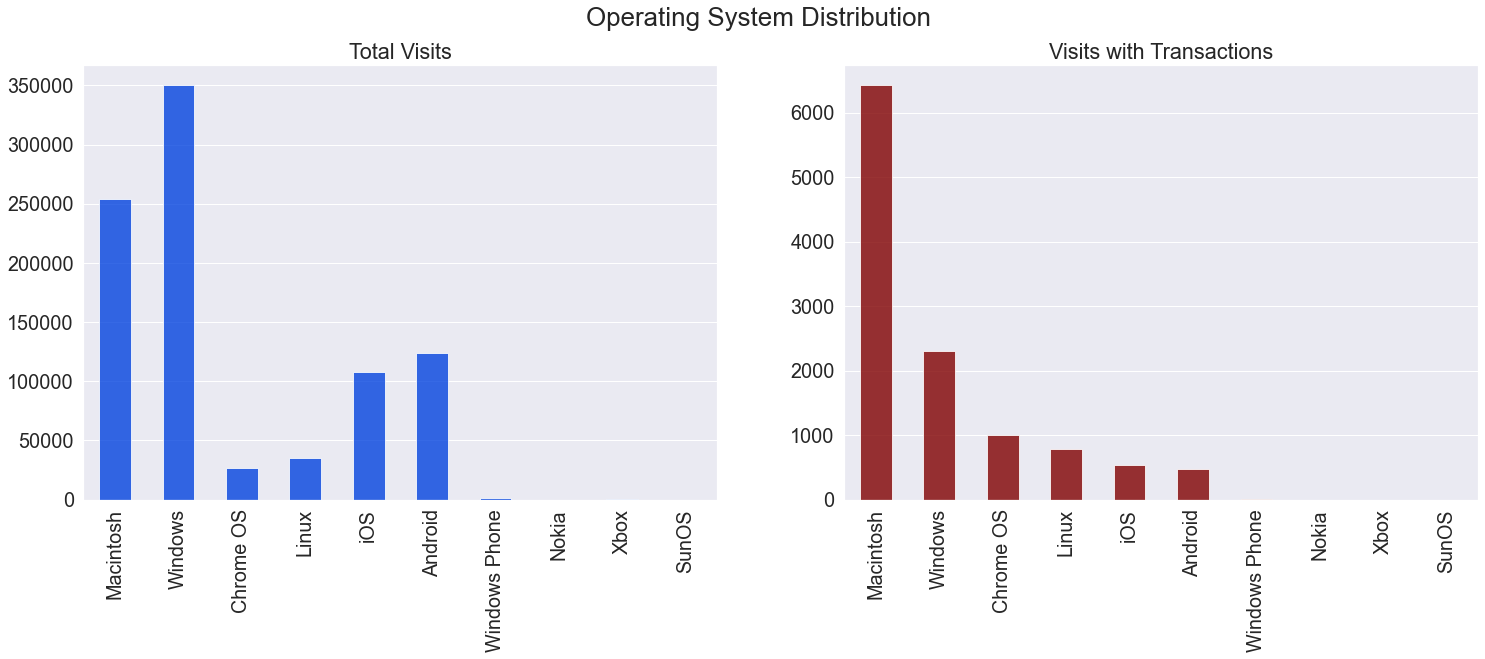

,Total Visits,Visits with Transactions
device.operatingSystem,,
Macintosh,253938,6426
Windows,350072,2309
Chrome OS,26337,994
Linux,35034,782
iOS,107665,536
Android,123892,467
Windows Phone,1216,1
Nokia,2,0
Xbox,66,0


In [13]:
# Operating System
cnt_os = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_os.columns = ["Total Visits", "Visits with Transactions"]
cnt_os = cnt_os.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Operating System Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_os["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_os["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_os

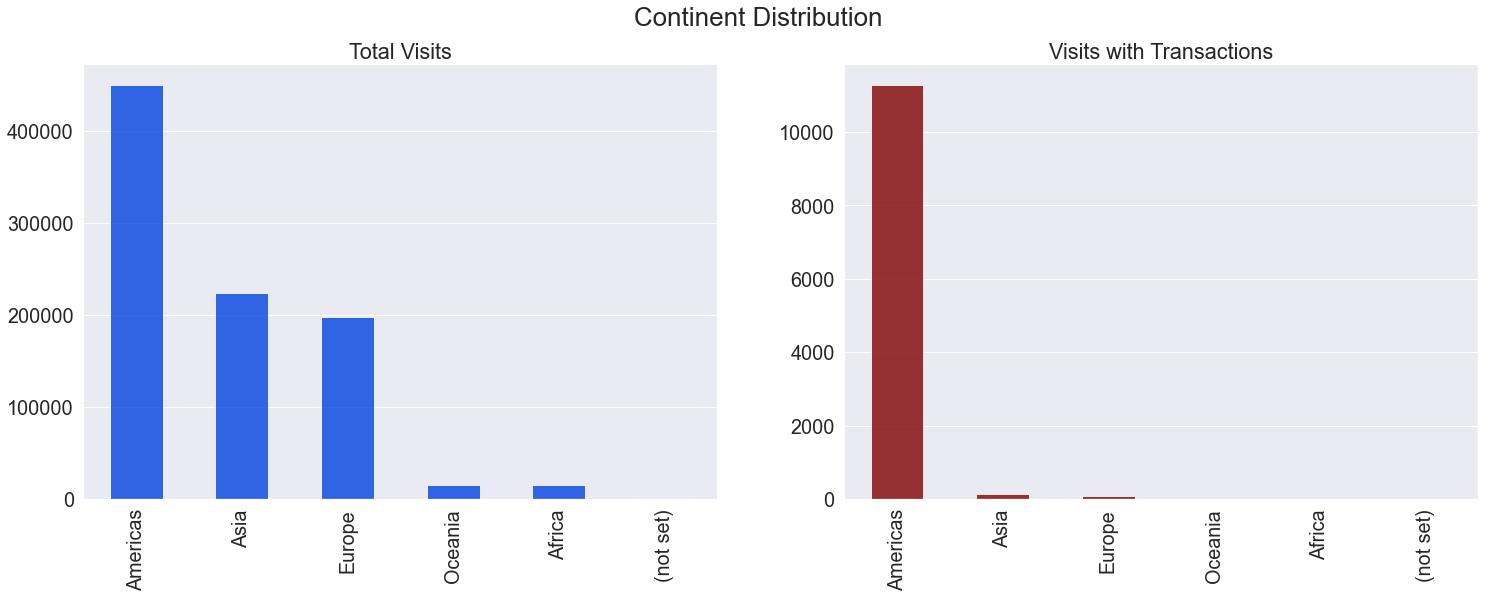

,Total Visits,Visits with Transactions
geoNetwork.continent,,
Americas,450377,11283
Asia,223698,125
Europe,198311,79
Oceania,15054,14
Africa,14745,8
(not set),1468,6


In [14]:
# Continent
cnt_cont = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_cont.columns = ["Total Visits", "Visits with Transactions"]
cnt_cont = cnt_cont.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Continent Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_cont["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_cont["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_cont

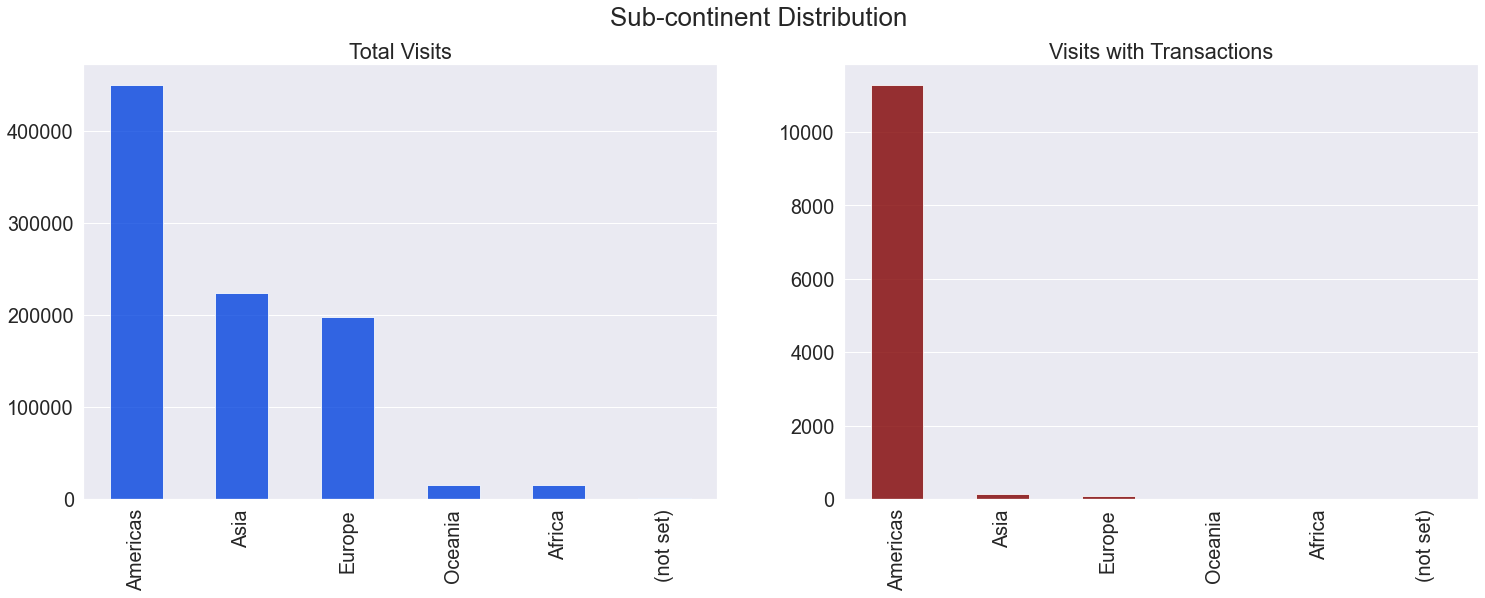

,Total Visits,Visits with Transactions
geoNetwork.continent,,
Americas,450377,11283
Asia,223698,125
Europe,198311,79
Oceania,15054,14
Africa,14745,8
(not set),1468,6


In [15]:
# Sub-continent
cnt_sub = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_sub.columns = ["Total Visits", "Visits with Transactions"]
cnt_sub = cnt_sub.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Sub-continent Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_sub["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_sub["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_sub

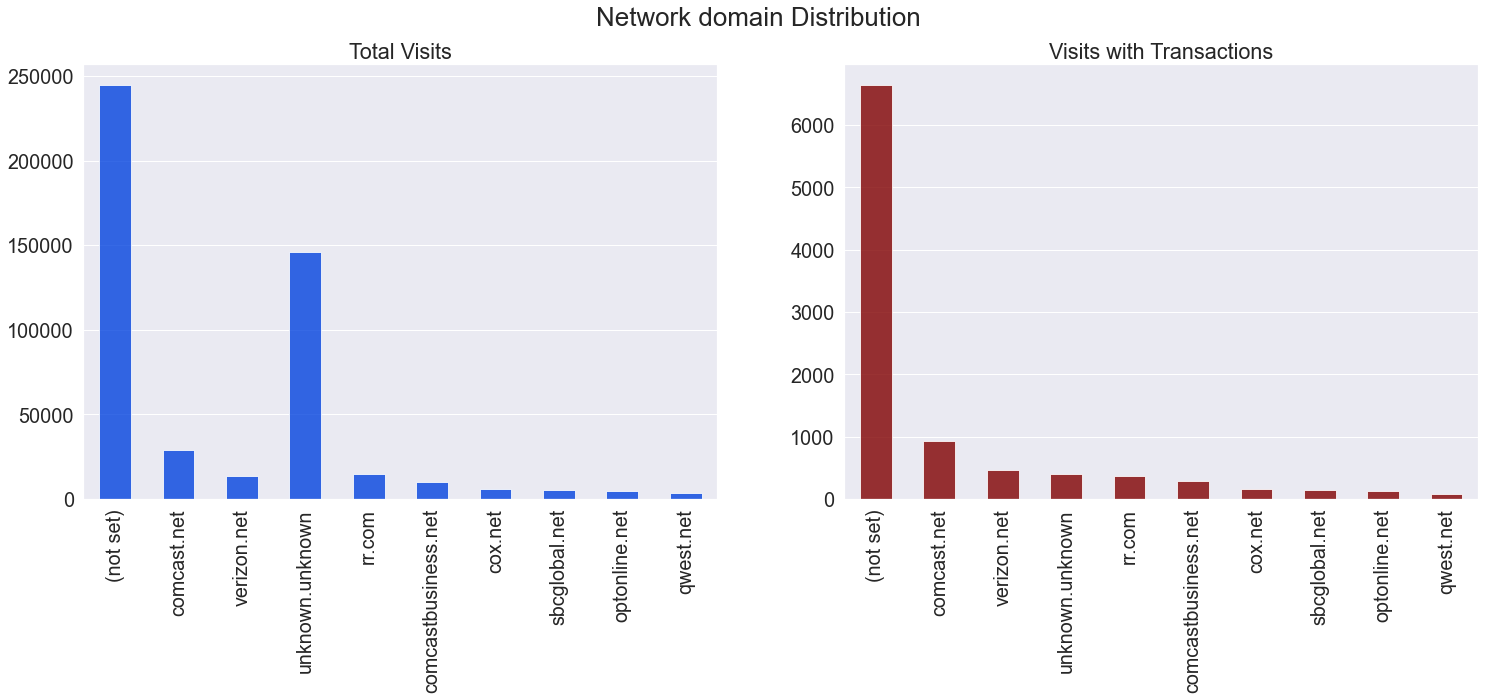

,Total Visits,Visits with Transactions
geoNetwork.networkDomain,,
(not set),244881,6645
comcast.net,28743,934
verizon.net,13637,469
unknown.unknown,146034,400
rr.com,14827,364
comcastbusiness.net,9985,294
cox.net,5812,156
sbcglobal.net,5388,150
optonline.net,4972,133


In [16]:
# Network domain
cnt_net = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_net.columns = ["Total Visits", "Visits with Transactions"]
cnt_net = cnt_net.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Network domain Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_net["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_net["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_net

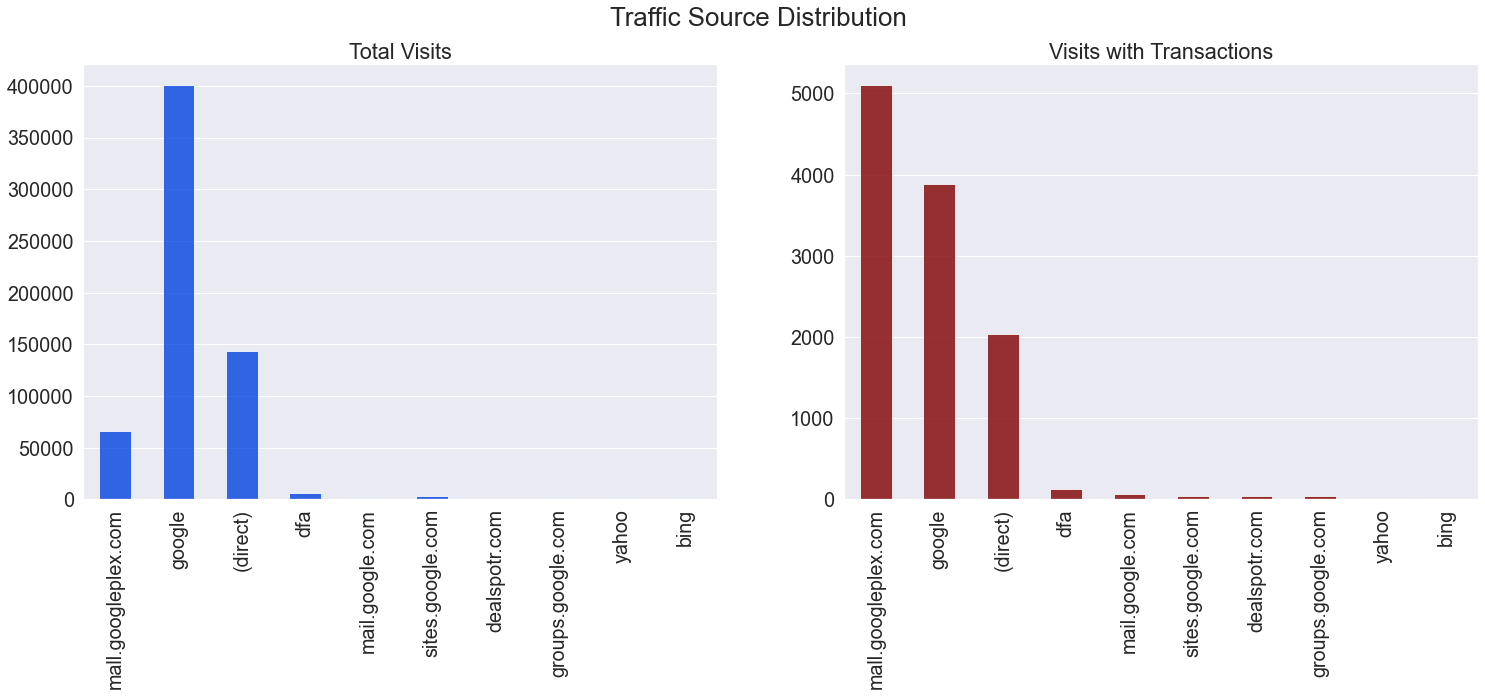

,Total Visits,Visits with Transactions
trafficSource.source,,
mall.googleplex.com,66416,5103
google,400788,3879
(direct),143028,2042
dfa,5686,123
mail.google.com,1457,62
sites.google.com,2983,42
dealspotr.com,528,40
groups.google.com,1025,38
yahoo,1480,22


In [17]:
# Traffic Source
cnt_ts = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_ts.columns = ["Total Visits", "Visits with Transactions"]
cnt_ts = cnt_ts.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Traffic Source Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_ts["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_ts["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_ts

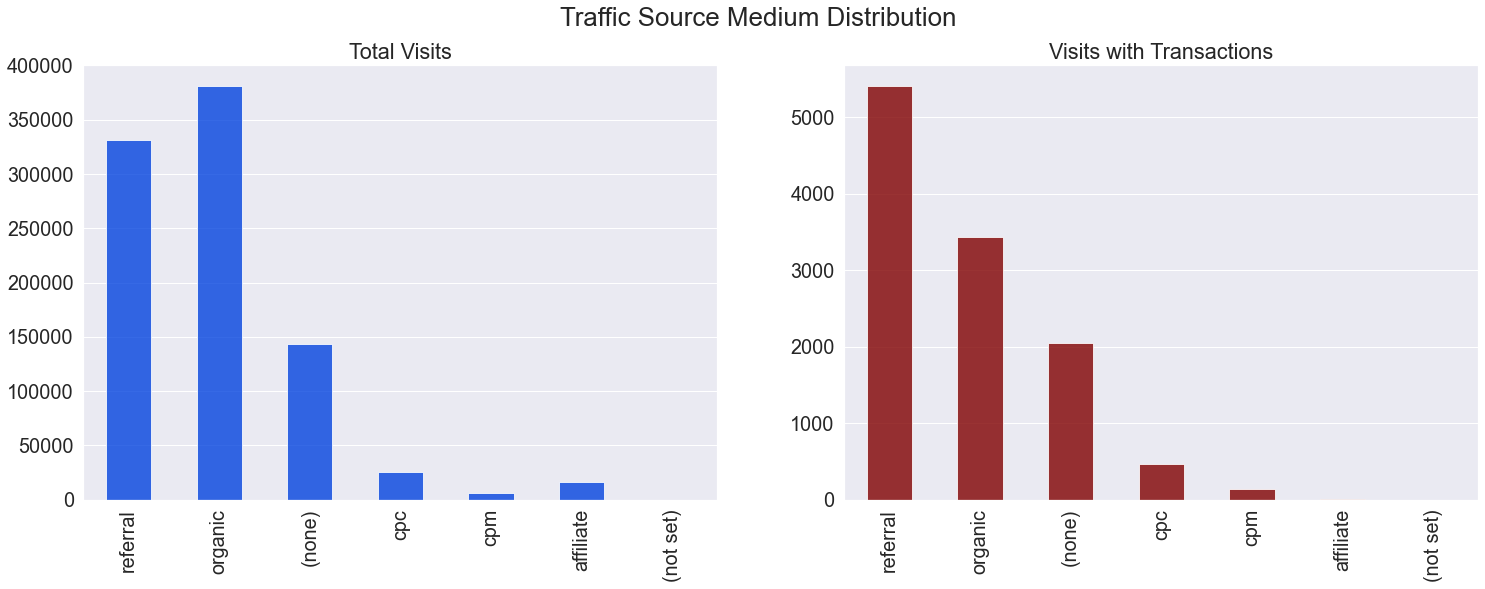

,Total Visits,Visits with Transactions
trafficSource.medium,,
referral,330955,5415
organic,381561,3438
(none),143026,2042
cpc,25326,468
cpm,6262,142
affiliate,16403,9
(not set),120,1


In [18]:
# Traffic Source Medium
cnt_tm = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_tm.columns = ["Total Visits", "Visits with Transactions"]
cnt_tm = cnt_tm.sort_values(by="Visits with Transactions", ascending=False).head(10)

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.8)
fig, ax = plt.subplots(1,2, figsize=(25, 8))
fig.suptitle('Traffic Source Medium Distribution')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

cnt_tm["Total Visits"].plot(kind='bar', color='#0343DF', alpha=0.8, ax=ax[0])

cnt_tm["Visits with Transactions"].plot(kind='bar', color='#800000', alpha=0.8, ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

        
plt.show()
cnt_tm

In [19]:
# splitting date and visitStartTime columns for further analysis 

def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["week_day"] = df['date'].dt.weekday #extracting week day
    df["month_day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df['visit_hour'] = (df['visitStartTime'].apply(lambda x: str(dt.datetime.fromtimestamp(x).hour))).astype(int)
    return df

In [20]:
train_df = date_process(train_df)
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode,week_day,month_day,month,year,visit_hour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,21
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,10
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,6
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,11
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,NaN,4,2,9,2016,18


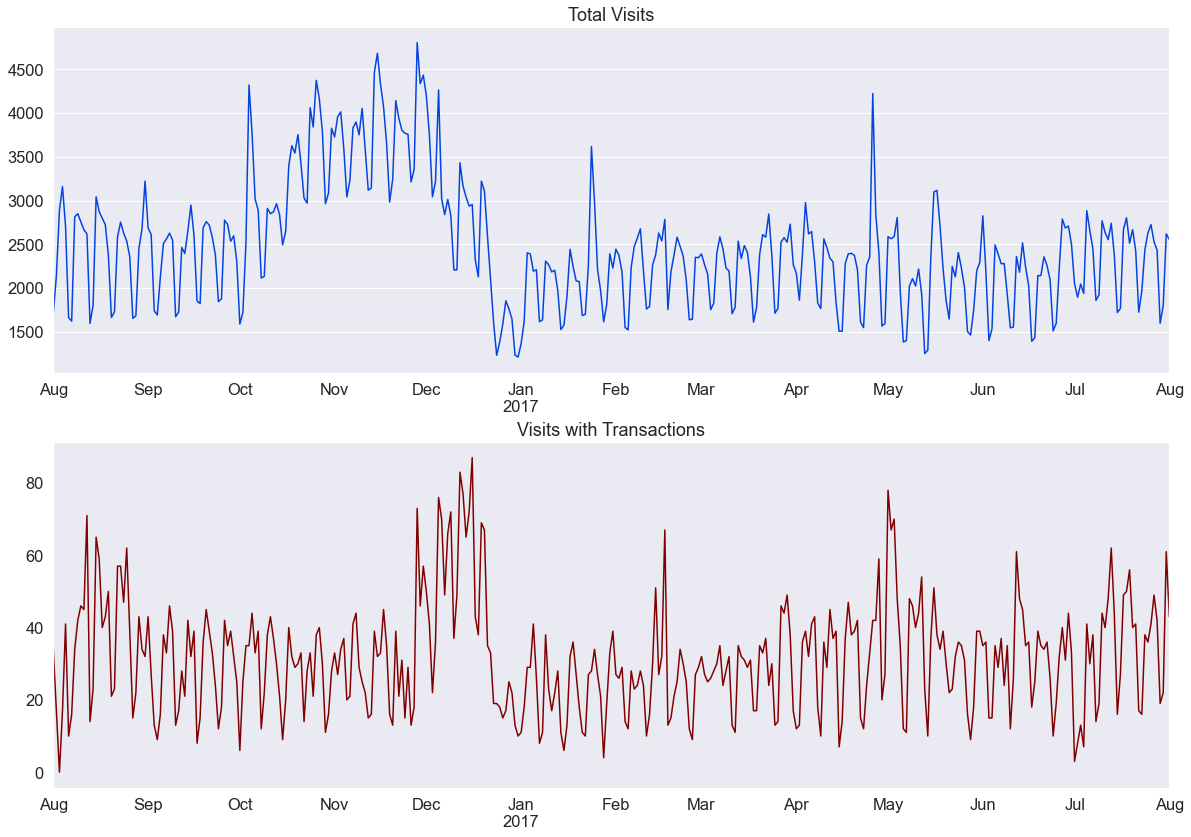

In [21]:
# Plots for count of visits and transactions based on time  

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()

fig, ax = plt.subplots(2, 1, figsize=(20, 14))
cnt_srs["count"].plot(color='#0343DF', ax=ax[0])
cnt_srs["count of non-zero revenue"].plot(color='#800000', ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

plt.grid(False)
plt.show()

In [22]:
#  VisitHour and weekday

date_sales = ['visit_hour', 'week_day']
cm = sns.color_palette("crest", as_cmap=True)
pd.crosstab(train_df[date_sales[0]], train_df[date_sales[1]]).style.background_gradient(cmap = cm)

week_day,0,1,2,3,4,5,6
visit_hour,,,,,,,
0,8122,8318,8362,8003,7200,4934,5041
1,7503,8015,7832,7402,6877,4844,4773
2,7473,7599,7492,7223,6438,4543,4687
3,6565,7068,6835,6534,6334,4291,4358
4,5823,6138,6103,6034,5726,3717,4056
5,5615,5670,5442,5399,4780,3508,3835
6,5314,5440,5203,5023,4155,3431,4164
7,5112,5346,5018,5186,4087,3478,4333
8,4938,5111,4968,4831,3981,3517,4183


Above table shows that visiting hours are at maximum between 8pm to 12am.   

<a id='4'></a>
## 5. Data Preprocessing

As found the summary table there few features with a single constant value and null values in the data set. These have to be removed before training

In [23]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

Additionally, the columns sessionId and trafficSource.campaignCode can be removed as well

In [24]:
drop_cols = const_cols + ['sessionId'] + ['trafficSource.campaignCode']

train_df.drop(drop_cols, axis=1, inplace=True)

In [25]:
df_summary(train_df)

Dataset Shape: (903653, 39)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,object,0,8,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,...,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
1,date,datetime64[ns],0,366,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,...,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00
2,fullVisitorId,object,0,714167,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085,2938943183656635653,...,0523069750702990437,982320996976275749,357659889600827884,1438082600262726746,3531015320757710684,9638207207743070032,9876750586615598787,2222266935962032743,9674781571160116268,3696906537737368442
3,visitId,int64,0,886303,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,...,1472834967,1472849434,1472839882,1472803483,1472868337,1472824614,1472801099,1472826820,1472804607,1472856874
4,visitNumber,int64,0,384,1,1,1,1,2,1,...,1,1,1,1,1,1,1,1,1,1
5,visitStartTime,int64,0,887159,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,...,1472834967,1472849434,1472839882,1472803483,1472868337,1472824614,1472801099,1472826820,1472804607,1472856874
6,device.browser,object,0,54,Chrome,Firefox,Chrome,UC Browser,Chrome,Chrome,...,Chrome,Safari,Safari,Safari,Chrome,Chrome,Chrome,Internet Explorer,Chrome,Chrome
7,device.operatingSystem,object,0,20,Windows,Macintosh,Windows,Linux,Android,Windows,...,Android,Macintosh,iOS,iOS,Linux,Macintosh,Windows,Windows,Windows,Windows
8,device.isMobile,bool,0,2,False,False,False,False,True,False,...,True,False,True,True,False,False,False,False,False,False
9,device.deviceCategory,object,0,3,desktop,desktop,desktop,desktop,mobile,desktop,...,tablet,desktop,mobile,mobile,desktop,desktop,desktop,desktop,desktop,desktop


<a id='4.1'></a>
## 5.1. Categorical Encoding and Imputing Missing Values

In [26]:
# Separating categorical and numerical columns further processing

cat_cols = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory', 'geoNetwork.continent',
'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city', 
'geoNetwork.networkDomain', 'trafficSource.campaign', 'trafficSource.source', 'trafficSource.medium',
'trafficSource.keyword', 'trafficSource.isTrueDirect', 'trafficSource.referralPath', 'trafficSource.adwordsClickInfo.page',
'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType',
'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent'] 


num_cols = ['visitNumber', 'totals.pageviews', 'totals.hits', 'totals.bounces', 'totals.newVisits', 'week_day',
            'month_day', 'month', 'year', 'visit_hour'] 

In [27]:
# Encoding categorical features

from sklearn.preprocessing import LabelEncoder

start = dt.datetime.now()
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(list(train_df[col].values.astype('str')))

print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 0:00:49.058482


In [28]:
# Converting numerical features into float

for col in num_cols:
    train_df[col] = train_df[col].astype(float)

In [29]:
train_df['totals.pageviews'].fillna(1, inplace=True) #imputing with 1 since min value has to be 1

In [30]:
train_df['totals.bounces'].value_counts()

1.0    450630
Name: totals.bounces, dtype: int64

In [31]:
train_df['totals.bounces'].fillna(0, inplace=True)   #imputing with 0

In [32]:
train_df['totals.newVisits'].value_counts()

1.0    703060
Name: totals.newVisits, dtype: int64

In [33]:
train_df['totals.newVisits'].fillna(0, inplace=True) #imputing with 0

In [34]:
train_df["totals.transactionRevenue"].fillna(0, inplace=True) #imputing with 0

In [35]:
df_summary(train_df)

Dataset Shape: (903653, 39)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,int64,0,8,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1,date,datetime64[ns],0,366,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,...,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00
2,fullVisitorId,object,0,714167,1131660440785968503,377306020877927890,3895546263509774583,4763447161404445595,27294437909732085,2938943183656635653,...,0523069750702990437,982320996976275749,357659889600827884,1438082600262726746,3531015320757710684,9638207207743070032,9876750586615598787,2222266935962032743,9674781571160116268,3696906537737368442
3,visitId,int64,0,886303,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,...,1472834967,1472849434,1472839882,1472803483,1472868337,1472824614,1472801099,1472826820,1472804607,1472856874
4,visitNumber,float64,0,384,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,visitStartTime,int64,0,887159,1472830385,1472880147,1472865386,1472881213,1472822600,1472807194,...,1472834967,1472849434,1472839882,1472803483,1472868337,1472824614,1472801099,1472826820,1472804607,1472856874
6,device.browser,int64,0,54,11,16,11,46,11,11,...,11,40,40,40,11,11,11,20,11,11
7,device.operatingSystem,int64,0,20,16,7,16,6,1,16,...,1,7,19,19,6,7,16,16,16,16
8,device.isMobile,bool,0,2,False,False,False,False,True,False,...,True,False,True,True,False,False,False,False,False,False
9,device.deviceCategory,int64,0,3,0,0,0,0,1,0,...,2,0,1,1,0,0,0,0,0,0


In [36]:
# Save preprocessed data
#df_tmp.to_csv(".csv", index=False)

<a id='4.2'></a>
## 5.2. Splitting data into train and test

In [37]:
# Split the train dataset into train and test based on time 

tr_df = train_df[train_df['date'].dt.date <= dt.date(2017,4,30)]
cv_df = train_df[(train_df['date'].dt.date > dt.date(2017,4,30)) & (train_df['date'].dt.date <= dt.date(2017,5,31)) ]
test_df = train_df[(train_df['date'].dt.date > dt.date(2017,5,31))]

In [38]:
# Taking log of skewed target variables

y_train = np.log1p(tr_df["totals.transactionRevenue"].values)
y_cv = np.log1p(cv_df["totals.transactionRevenue"].values)
y_test = np.log1p(test_df["totals.transactionRevenue"].values)

In [39]:
# Only selecting necessary features for training

X_train = tr_df[cat_cols + num_cols] 
X_cv = cv_df[cat_cols + num_cols] 
X_test = test_df[cat_cols + num_cols]

X_train.shape, X_cv.shape, X_test.shape

((700336, 33), (65371, 33), (137946, 33))

In [40]:
df_summary(X_train)

Dataset Shape: (700336, 33)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,int64,0,8,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,device.browser,int64,0,50,11.0,16.0,11.0,46.0,11.0,11.0,...,11.0,40.0,40.0,40.0,11.0,11.0,11.0,20.0,11.0,11.0
2,device.operatingSystem,int64,0,20,16.0,7.0,16.0,6.0,1.0,16.0,...,1.0,7.0,19.0,19.0,6.0,7.0,16.0,16.0,16.0,16.0
3,device.deviceCategory,int64,0,3,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,geoNetwork.continent,int64,0,6,3.0,5.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0
5,geoNetwork.subContinent,int64,0,23,21.0,1.0,19.0,16.0,13.0,19.0,...,18.0,22.0,21.0,18.0,15.0,6.0,22.0,22.0,16.0,15.0
6,geoNetwork.country,int64,0,218,204.0,12.0,181.0,94.0,211.0,100.0,...,93.0,69.0,204.0,152.0,28.0,43.0,142.0,69.0,174.0,9.0
7,geoNetwork.region,int64,0,357,150.0,375.0,78.0,375.0,375.0,375.0,...,375.0,375.0,150.0,297.0,375.0,375.0,375.0,144.0,0.0,53.0
8,geoNetwork.metro,int64,0,87,0.0,93.0,0.0,93.0,93.0,93.0,...,93.0,93.0,0.0,0.0,93.0,93.0,93.0,0.0,0.0,0.0
9,geoNetwork.city,int64,0,599,258.0,648.0,325.0,648.0,648.0,648.0,...,648.0,648.0,258.0,269.0,648.0,648.0,648.0,431.0,544.0,93.0


In [41]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

<a id='5'></a>
## 6. Training Models

<a id='5.1'></a>
## 6.1. LightGBM Regressor

In [42]:
# Error plot helper

def plot_cv_error(loss, hyp):
    best_hyp = np.argmin(loss)
    
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#f7f7f7')
    ax.plot(hyp, loss, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    

    # text for the box
    textstr = '\n'.join((f'Best min_leaf: {hyp[best_hyp]}',
                    f'Lowest RMSE: %.3f'% np.min(loss)))
   
    # place a text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.70, 0.20, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.set_title("Cross Validation Error for each min_leaf")
    ax.set_xlabel("Hyperparameter min_leaf")
    ax.set_ylabel("RMSE")
    plt.grid(True)
    plt.show()   

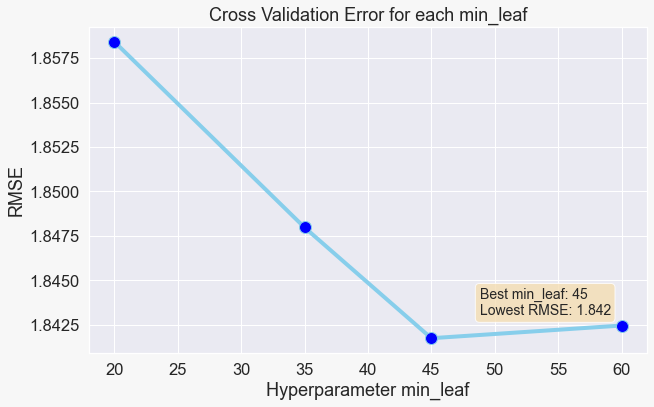

For values of best min_leaf = 45 The train RMSE is: 1.48
For values of best min_leaf = 45 The test RMSE is: 1.73
Time taken to run this cell : 0:00:23.405277


In [43]:
from lightgbm import LGBMRegressor as lgb
from sklearn.metrics import mean_squared_error

start = dt.datetime.now()

cv_error_array=[]
leaf = [20, 35, 45, 60]

for i in leaf:
    lgbr = lgb(num_leaves=i)
    lgbr.fit(X_train, y_train)
    predict_y = lgbr.predict(X_cv)
    cv_error_array.append(np.sqrt(mean_squared_error(y_cv, predict_y)))

best_leaf = np.argmin(cv_error_array)

lgbr = lgb(num_leaves=leaf[best_leaf])
lgbr.fit(X_train, y_train)

plot_cv_error(cv_error_array, leaf)
predict_y_train = lgbr.predict(X_train)
print('For values of best min_leaf =', leaf[best_leaf], "The train RMSE is: %.2f" %np.sqrt(mean_squared_error(y_train, predict_y_train)))
predict_y_test = lgbr.predict(X_test)
print('For values of best min_leaf =', leaf[best_leaf], "The test RMSE is: %.2f" %np.sqrt(mean_squared_error(y_test, predict_y_test)))

                          
print("Time taken to run this cell :", dt.datetime.now() - start)

In [44]:
# check predefined metric
predict_y_test[predict_y_test< 0] = 0

test_pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
test_pred_df["transactionRevenue"] = test_df["totals.transactionRevenue"].values
test_pred_df["PredictedRevenue"] = np.expm1(predict_y_test)

test_pred_df = test_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(mean_squared_error(np.log1p(test_pred_df["transactionRevenue"].values), np.log1p(test_pred_df["PredictedRevenue"].values))))


C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_7808/3289363419.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_pred_df = test_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()


1.7699792677775523


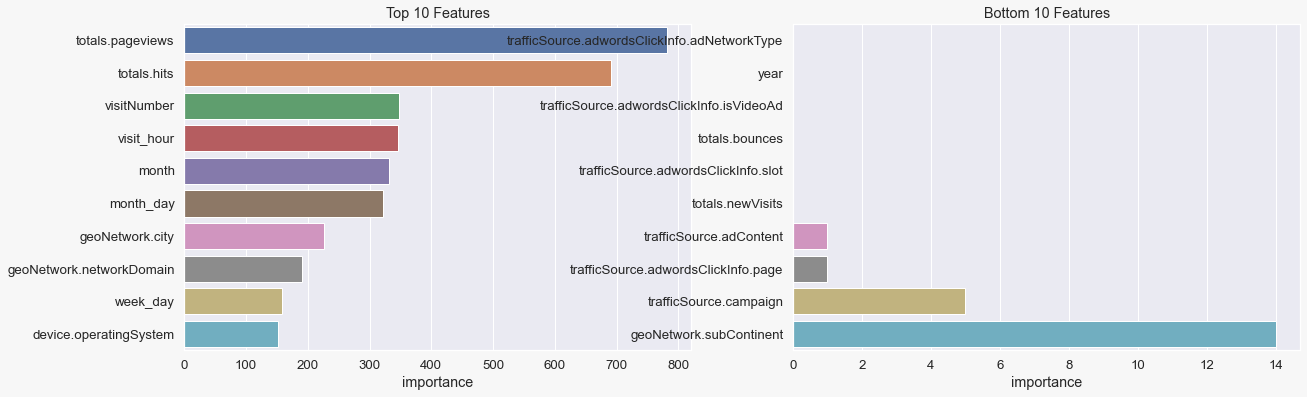

In [46]:
# Plot Feature Importance

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

feat_imp_df = pd.DataFrame()
feat_imp_df["feature"] = cat_cols + num_cols
feat_imp_df["importance"] = lgbr.feature_importances_
top_imp_df = feat_imp_df.sort_values(by="importance", ascending=False).head(10)
bot_imp_df = feat_imp_df.sort_values(by="importance", ascending=True).head(10)


fig, ax = plt.subplots(1,2, figsize=(20, 6), facecolor='#f7f7f7')

sns.barplot(x="importance", y="feature", ax=ax[0], data=top_imp_df)
sns.barplot(x="importance", y="feature", ax=ax[1], data=bot_imp_df)

ax[0].set_title('Top 10 Features')
ax[1].set_title('Bottom 10 Features')

for axes in ax:
    axes.set(ylabel=None)

plt.show()